In [1]:
# Dependencies
import requests
import pandas as pd
from census import Census
import hvplot.pandas
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import linregress

In [2]:
# Import U.S. Census API Key
from config import api_key
if api_key == "YOUR KEY HERE":
    print("Please edit your config.py file.")
    
# Create an instance of the Census library
c = Census(api_key)

In [3]:
# Variables 
#B08301_001E is the estimated total workers
#B08301_021E is the estimated workers who worked from home

variables = ['B08301_001E', 'B08301_021E']

# Years we are looking at
years = [2020, 2021, 2022]

# FIPS code to state names
names_state = {
    '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California',
    '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware', '11': 'District of Columbia',
    '12': 'Florida', '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois',
    '18': 'Indiana', '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana',
    '23': 'Maine', '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota',
    '28': 'Mississippi', '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada',
    '33': 'New Hampshire', '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', '37': 'North Carolina',
    '38': 'North Dakota', '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon', '42': 'Pennsylvania',
    '44': 'Rhode Island', '45': 'South Carolina', '46': 'South Dakota', '47': 'Tennessee', '48': 'Texas',
    '49': 'Utah', '50': 'Vermont', '51': 'Virginia', '53': 'Washington', '54': 'West Virginia',
    '55': 'Wisconsin', '56': 'Wyoming', '72': 'Puerto Rico'
}

# List to store the data for all years
all_states = []

In [4]:
# Loop through each year 
for year in years:
    # Get the data for all states for this year
    data = c.acs5.get(variables, geo={"for": "state:*"}, year=year)
    
    # Convert the list of lists to a DataFrame
    wfh_df = pd.DataFrame(data[1:], columns=data[0])
    
    # Add the year as a column to the DataFrame
    wfh_df['year'] = year
    
    # State FIPS codes to state names
    wfh_df['names_state'] = wfh_df['state'].map(names_state)
    
    # Append this year's data to the all_data list
    all_states.append(wfh_df)

# Create the DataFrame 
wfh_df = pd.concat(all_states, ignore_index=True)

# Display the columns: State Name, Year, Total Workers, Workers Who Work From Home
wfh_df = wfh_df[['names_state', 'year', 'B08301_001E', 'B08301_021E']]

# Rename the columns
wfh_df.columns = ['State', 'Year', 'Total Workers', 'Workers Who Work From Home']

# Convert the 'Total Workers' and 'Workers Who Work From Home' columns to numeric values because strings will prevent numeric operations
wfh_df['Total Workers'] = wfh_df['Total Workers'].astype(int)
wfh_df['Workers Who Work From Home'] = wfh_df['Workers Who Work From Home'].astype(int)

# Calculate the percentage of workers who work from home
wfh_df['Percentage of Workers Who Work From Home'] = (
    wfh_df['Workers Who Work From Home'] / wfh_df['Total Workers']
) * 100

# Format the percentage column to two decimal places
wfh_df['Percentage of Workers Who Work From Home'] = wfh_df['Percentage of Workers Who Work From Home'].apply(lambda x: "{:.2f}%".format(x))

# Display the DataFrame
wfh_df

,State,Year,Total Workers,Workers Who Work From Home,Percentage of Workers Who Work From Home
0,California,2020,18239892,1529697,8.39%
1,West Virginia,2020,730395,33353,4.57%
2,Utah,2020,1517044,138218,9.11%
3,New York,2020,9219025,634197,6.88%
4,District of Columbia,2020,379090,46472,12.26%
...,...,...,...,...,...
148,Washington,2022,3722716,575184,15.45%
149,West Virginia,2022,723217,49655,6.87%
150,Wisconsin,2022,2974249,300409,10.10%
151,Wyoming,2022,284555,21902,7.70%


In [5]:
#Ensure the 'Percentage of Workers Who Work From Home' column is numeric
wfh_df['Percentage of Workers Who Work From Home'] = wfh_df['Percentage of Workers Who Work From Home'].apply(
    lambda x: float(x.replace('%', '').replace(',', '')) if isinstance(x, str) else x
)

# Handle NaNs in the Percentage calculation
wfh_df['Percentage of Workers Who Work From Home'] = wfh_df['Percentage of Workers Who Work From Home'].fillna(0)

#Group by 'State' and 'Year' and calculate the mean
mean_df = wfh_df.groupby(['State', 'Year'])['Percentage of Workers Who Work From Home'].mean().reset_index()

#Pivot the data
wfh_percentage_df = mean_df.pivot(index='State', columns='Year', values='Percentage of Workers Who Work From Home')

#Fill any NaN values with 0
wfh_percentage_df = wfh_percentage_df.fillna("0")

# Clean up the column name
wfh_percentage_df.columns = [f"Percentage of Workers Who Work From Home ({year})" for year in wfh_percentage_df.columns]

#Format the values back to percentage
wfh_percentage_df = wfh_percentage_df.map(lambda x: f"{x:.2f}%" if isinstance(x, (float, int)) else x)

# Reset index to make 'State' a column
wfh_percentage_df.reset_index

# Display the Dataframe
wfh_percentage_df.head()

,Percentage of Workers Who Work From Home (2020),Percentage of Workers Who Work From Home (2021),Percentage of Workers Who Work From Home (2022)
State,,,
Alabama,4.43%,0,0
Alaska,6.03%,7.09%,8.06%
Arizona,8.88%,11.71%,14.26%
Arkansas,4.37%,5.63%,6.75%
California,8.39%,11.36%,13.63%


In [6]:
#Trying to sort by greatest to lowest value for percentage of workers who work from home
#Convert the percentage column to numeric for sorting
wfh_percentage_df_numeric = wfh_percentage_df.map(lambda x: float(x.replace('%', '').replace(',', '')) if isinstance(x, str) else x)

#Identify only the columns that contain the percentages (for each year)
percentage_columns = [col for col in wfh_percentage_df_numeric.columns if 'Percentage of Workers Who Work From Home' in col]

# Sort the DataFrame by those percentage columns
wfh_percentage_df_sorted = wfh_percentage_df_numeric.sort_values(by=percentage_columns, ascending=False)

# Convert the numeric values back to percentage format
wfh_percentage_df_sorted = wfh_percentage_df_sorted.map(lambda x: f"{x:.2f}%" if isinstance(x, (float, int)) else x)

# Reset the index to make 'State' a column again
wfh_percentage_df_sorted = wfh_percentage_df_sorted.reset_index()

# Set 'State' as the index of the DataFrame
wfh_percentage_df_sorted = wfh_percentage_df_sorted.set_index('State')

# Display the sorted DataFrame
wfh_percentage_df_sorted.head()

,Percentage of Workers Who Work From Home (2020),Percentage of Workers Who Work From Home (2021),Percentage of Workers Who Work From Home (2022)
State,,,
District of Columbia,12.26%,19.83%,25.03%
Colorado,10.80%,13.99%,16.49%
Oregon,9.41%,12.51%,14.95%
Utah,9.11%,11.80%,14.07%
Vermont,9.04%,11.44%,13.24%


In [7]:
# Save the DataFrame to a CSV file
wfh_percentage_df_sorted.to_csv("./Resources/wfh_percentage_df_sorted.csv")

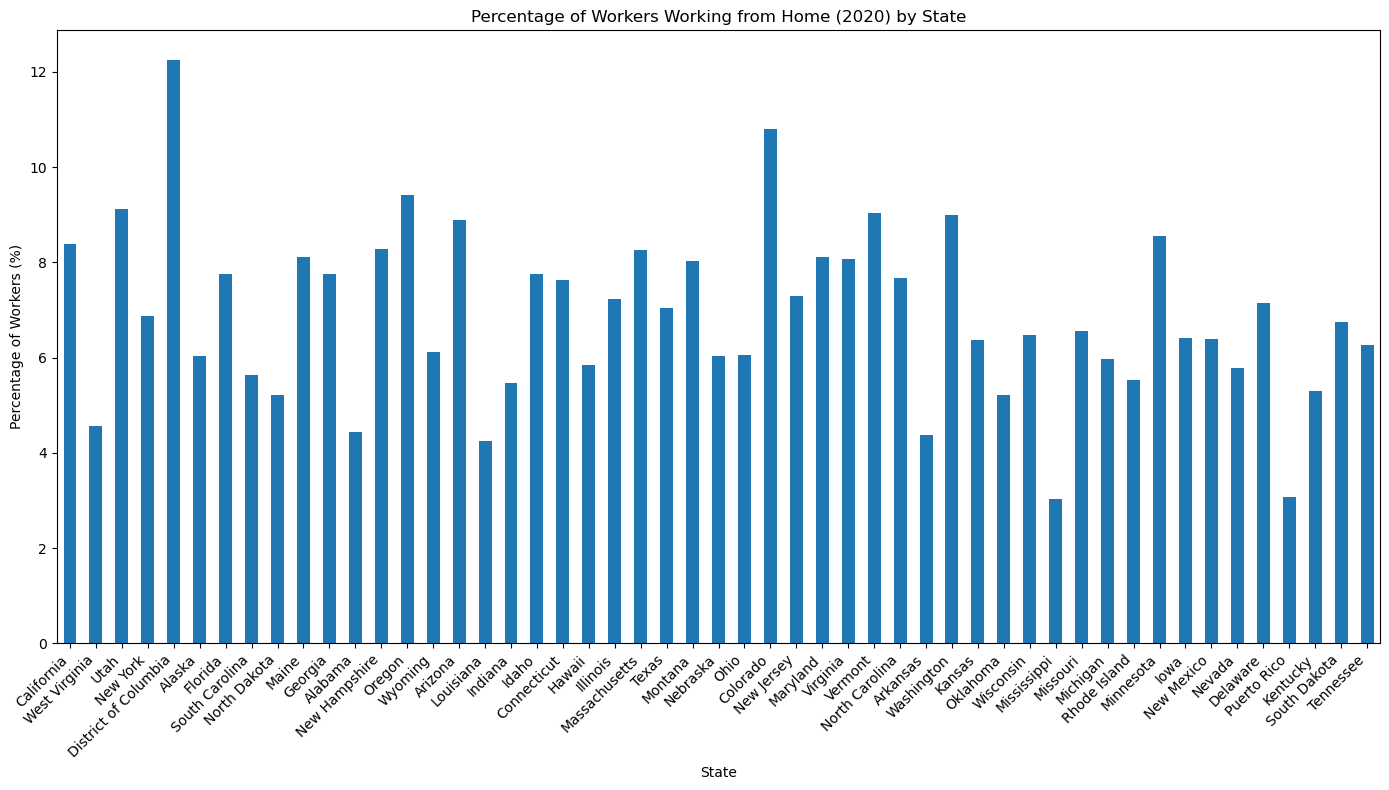

In [8]:
# Creating a 2020 bar graph with the wfh_df DataFrame 
# First, calculate the percentage for year 2020
wfh_df['Percentage of Workers Who Work From Home'] = (
    wfh_df['Workers Who Work From Home'] / wfh_df['Total Workers']
) * 100

#Plotting year 2020 data
wfh_percentage_df_2020 = wfh_df[wfh_df['Year'] == 2020].set_index('State')
ax = wfh_percentage_df_2020['Percentage of Workers Who Work From Home'].plot(kind='bar', figsize=(14, 8))
plt.title('Percentage of Workers Working from Home (2020) by State')
plt.ylabel('Percentage of Workers (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('./Images/wfh_percentage_2020.png')
            
plt.show()

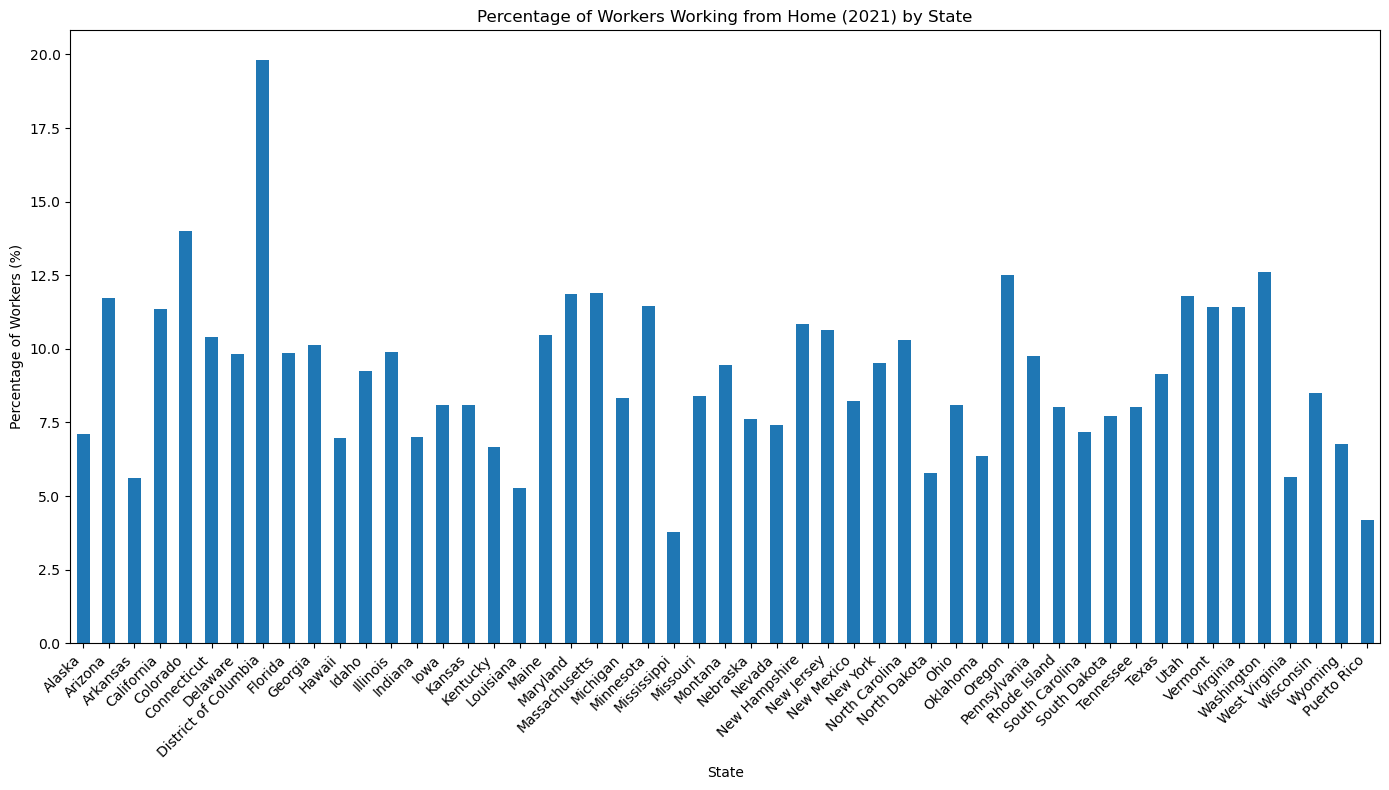

In [9]:
# Plotting for year 2021 data
wfh_percentage_df_2021 = wfh_df[wfh_df['Year'] == 2021].set_index('State')
ax = wfh_percentage_df_2021['Percentage of Workers Who Work From Home'].plot(kind='bar', figsize=(14, 8))
plt.title('Percentage of Workers Working from Home (2021) by State')
plt.ylabel('Percentage of Workers (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('./Images/wfh_percentage_2021.png')

plt.show()

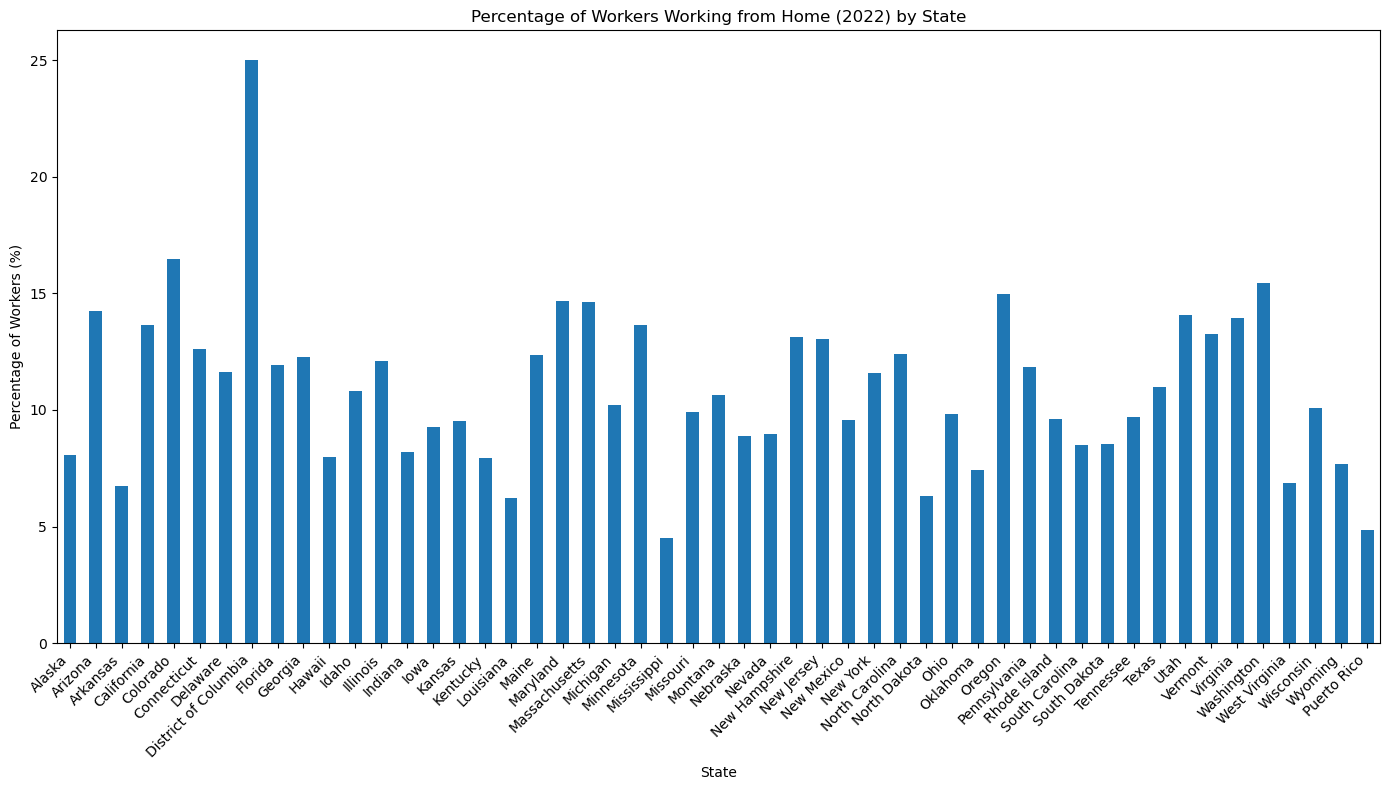

In [10]:
# Plotting for year 2022 data
wfh_percentage_df_2022 = wfh_df[wfh_df['Year'] == 2022].set_index('State')
ax = wfh_percentage_df_2022['Percentage of Workers Who Work From Home'].plot(kind='bar', figsize=(14, 8))
plt.title('Percentage of Workers Working from Home (2022) by State')
plt.ylabel('Percentage of Workers (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('./Images/wfh_percentage_2022.png')

plt.show()

In [11]:
# Variables for male and female workers
gender_total = {
    'Male': {
        'total_workers': 'B08406_018E',
        'wfh_workers': 'B08406_034E'
    },
    'Female': {
        'total_workers': 'B08406_035E',
        'wfh_workers': 'B08406_051E'
    }
}

# Years we are looking at
years = [2020, 2021, 2022]

# List to store data for all years
all_data_gender = []

In [12]:
# Loop through each year to get data for males and females
for year in years:
    for gender in gender_total:
        # Get the codes for the total workers and worked from home workers
        total_workers_code = gender_total[gender]['total_workers']
        wfh_workers_code = gender_total[gender]['wfh_workers']
        
        # Get the data for all states for this year and gender
        data = c.acs5.get([total_workers_code, wfh_workers_code], geo={"for": "state:*"}, year=year)
        
        # Process the data into a structured format
        for row in data:
            state_code = row['state']
            state_name = names_state.get(state_code, 'Unknown')
            total_workers = row.get(total_workers_code, None)
            wfh_workers = row.get(wfh_workers_code, None)
            
            # Calculate the percentage of workers working from home
            if total_workers and total_workers > 0:
                percentage_wfh = (wfh_workers / total_workers) * 100 if wfh_workers else 0
            else:
                percentage_wfh = 0
            
            # Only append the data we want
            gender_data = {
                'State': state_name,
                'Year': year,
                'Gender': gender,
                'Percentage Worked From Home': percentage_wfh
            }
            
            # Append the data for this state and gender to the all_data_gender list
            all_data_gender.append(gender_data)

# Convert to a DataFrame
gender_df = pd.DataFrame(all_data_gender)


In [13]:
# Convert values to numeric where necessary
gender_df['Percentage Worked From Home'] = pd.to_numeric(gender_df['Percentage Worked From Home'], errors='coerce')

# Pivot the data so that each year/gender has its own column
gender_percentage_df = gender_df.pivot_table(
    index='State', 
    columns=['Year', 'Gender'], 
    values='Percentage Worked From Home', 
    aggfunc='mean'
)

# Flatten the multi-level columns for easier access
gender_percentage_df.columns = [f"{year} {gender} Percentage Worked From Home" for year, gender in gender_percentage_df.columns]

# Format the percentage columns to show 2 decimal places and add the '%' symbol
gender_percentage_df = gender_percentage_df.map(lambda x: f"{x:.2f}%" if pd.notnull(x) else None)

# Display the DataFrame
gender_percentage_df

,2020 Female Percentage Worked From Home,2020 Male Percentage Worked From Home,2021 Female Percentage Worked From Home,2021 Male Percentage Worked From Home,2022 Female Percentage Worked From Home,2022 Male Percentage Worked From Home
State,,,,,,
Alabama,4.88%,4.20%,6.18%,5.32%,7.45%,6.17%
Alaska,7.46%,4.67%,9.07%,5.27%,10.16%,6.15%
Arizona,10.13%,7.94%,13.22%,10.60%,16.10%,12.92%
Arkansas,4.78%,4.01%,6.11%,5.19%,7.40%,6.17%
California,9.31%,7.61%,12.53%,10.37%,15.02%,12.47%
Colorado,12.00%,9.83%,15.38%,12.89%,18.03%,15.25%
Connecticut,8.15%,7.51%,11.22%,10.15%,13.68%,12.31%
Delaware,7.15%,7.18%,10.12%,9.61%,12.25%,11.14%
District of Columbia,6.35%,5.09%,10.72%,8.37%,13.92%,11.08%


In [14]:
# To create a regression for female workers who work from home, firt remove the '%' symbol and convert columns to numeric
gender_percentage_df = gender_percentage_df.replace('%', '', regex=True).astype(float)

# Filter out only female worker data (for all years and all states)
female_data = gender_percentage_df[['2020 Female Percentage Worked From Home',
                                     '2021 Female Percentage Worked From Home',
                                     '2022 Female Percentage Worked From Home']]

# Drop rows with NaN values (because some states might have missing data)
female_data = female_data.dropna()

The r-squared value is: 0.32509814477099036


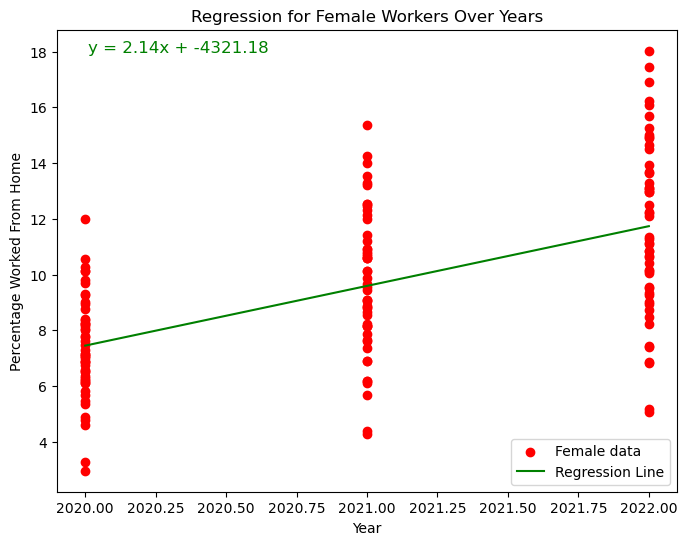

In [15]:
# Check if there is enough data
if len(female_data) > 0:
    # The years we are analyzing
    x = np.array([2020, 2021, 2022])  
    
    # Flatten to get a 1D array of female worker percentages across all years
    y = female_data.values.flatten()  

    # Create an x-axis array for each state, each year repeated
    x_extended = np.tile(x, len(female_data))

    # Perform linear regression
    slope, intercept, rvalue, pvalue, stderr = linregress(x_extended, y)
    regress_values = x_extended * slope + intercept
    line_eq = f"y = {round(slope, 2)}x + {round(intercept, 2)}"
    
    # Plotting the data 
    plt.figure(figsize=(8, 6))
    plt.scatter(x_extended, y, color='red', label='Female data')  # Scatter plot for individual state data points
    plt.plot(x_extended, regress_values, 'g-', label='Regression Line')  # Regression line
    
    # Annotate the regression equation on the plot
    plt.annotate(line_eq, (0.05, 0.95), xycoords='axes fraction', fontsize=12, color="green")

    # Labeling
    plt.title("Regression for Female Workers Over Years")
    plt.xlabel("Year")
    plt.ylabel("Percentage Worked From Home")
    plt.legend()

    # Print the r-squared value
    print(f"The r-squared value is: {rvalue**2}")

    # Show the plot
    plt.savefig('./Images/wfh_female_regression.png')
    plt.show()
else:
    print("Not enough data to perform regression for Female workers.")

In [16]:
# To create a regression for female workers who work from home, firt remove the '%' symbol and convert columns to numeric
gender_percentage_df = gender_percentage_df.replace('%', '', regex=True).astype(float)

# Extract columns for male workers working from home for each year
male_data = gender_percentage_df[['2020 Male Percentage Worked From Home',
                                   '2021 Male Percentage Worked From Home',
                                   '2022 Male Percentage Worked From Home']]

# Drop rows with NaN values (some states might have missing data)
male_data = male_data.dropna()

The r-squared value is: 0.27644518369248916


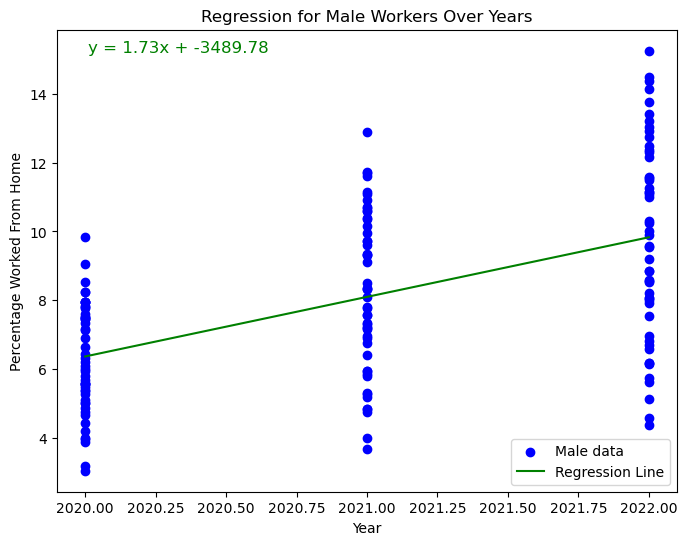

In [17]:
# Check if there is enough data
if len(male_data) > 0:
    
    # The years we are analyzing
    years = [2020, 2021, 2022]
    x = np.array([2020, 2021, 2022])  # Year values
    
    # Flatten to get a 1D array of female worker percentages across all years
    y = male_data.values.flatten() 

    # Extend x values to match the flattened y (repeating each year for all states)
    x_extended = np.tile(x, len(male_data))

    # Perform linear regression
    slope, intercept, rvalue, pvalue, stderr = linregress(x_extended, y)
    regress_values = x_extended * slope + intercept
    line_eq = f"y = {round(slope, 2)}x + {round(intercept, 2)}"
    
    # Plotting the data
    plt.figure(figsize=(8, 6))
    plt.scatter(x_extended, y, color='blue', label='Male data')  # Scatter plot for individual state data points
    plt.plot(x_extended, regress_values, 'g-', label='Regression Line')  # Regression line
    
    # Annotating the equation of the regression line on the plot
    plt.annotate(line_eq, (0.05, 0.95), xycoords='axes fraction', fontsize=12, color="green")

    # Labeling
    plt.title("Regression for Male Workers Over Years")
    plt.xlabel("Year")
    plt.ylabel("Percentage Worked From Home")
    plt.legend()

    # Print out the r-squared value
    print(f"The r-squared value is: {rvalue**2}")

    # Show the plot
    plt.savefig('./Images/wfh_male_regression.png')
    plt.show()
else:
    print("Not enough data to perform regression for Male workers.")